
# override mechanism:

## i think 2 of this class take info from robot_description (xacro), then set in to the interface (state, command interface)

### for gazebo -> if we use only gazebo simulation (create plugin unitree_gazebo/UnitreeGazeboSystem, we dont use the package inside gazebo_ros2_control)

+ UnitreeGazeboSystem override gazebo_ros2_control::GazeboSystemInterface => on_init(take infor )
    on_init(hardware_interface::HardwareInfo) 
    to load parameter via hardware_interface::SystemInterface::on_init(info) 

    + from this UnitreeGazeboSystem, we export state, command interface (export_state_interfaces()...)

### for real robot  -> if we working with the real A1 (create plugin unitree_hardware/UnitreeHardware)

+ so to send the command as in A1-ROS2_AIDA, we need to modify the API in this unitree_hardware

+ UnitreeHardware override hardware_interface::SystemInterface 

    1 on_init(hardware_interface::HardwareInfo)
    to load parameter via hardware_interface::SystemInterface::on_init(info) 

    -> take info from xacro (most probably)?? -> it take from config file inside the unitree_hardware
    then set up that these params received

    + from this GazeboSystem, we export state, command interface (export_state_interfaces()...)

## for common control -> create plugin unitree_controller/UnitreeController, which i cna not load 

+ UnitreeController override UnitreeControllerInterface

    + UnitreeControllerInterface override controller_interface::ControllerInterface

        on_init() run the UnitreeController::declare_parameters(joints, states, rate)  from controller.yaml,
        then it tries to match these parameter to the interface loaded by 2 method above


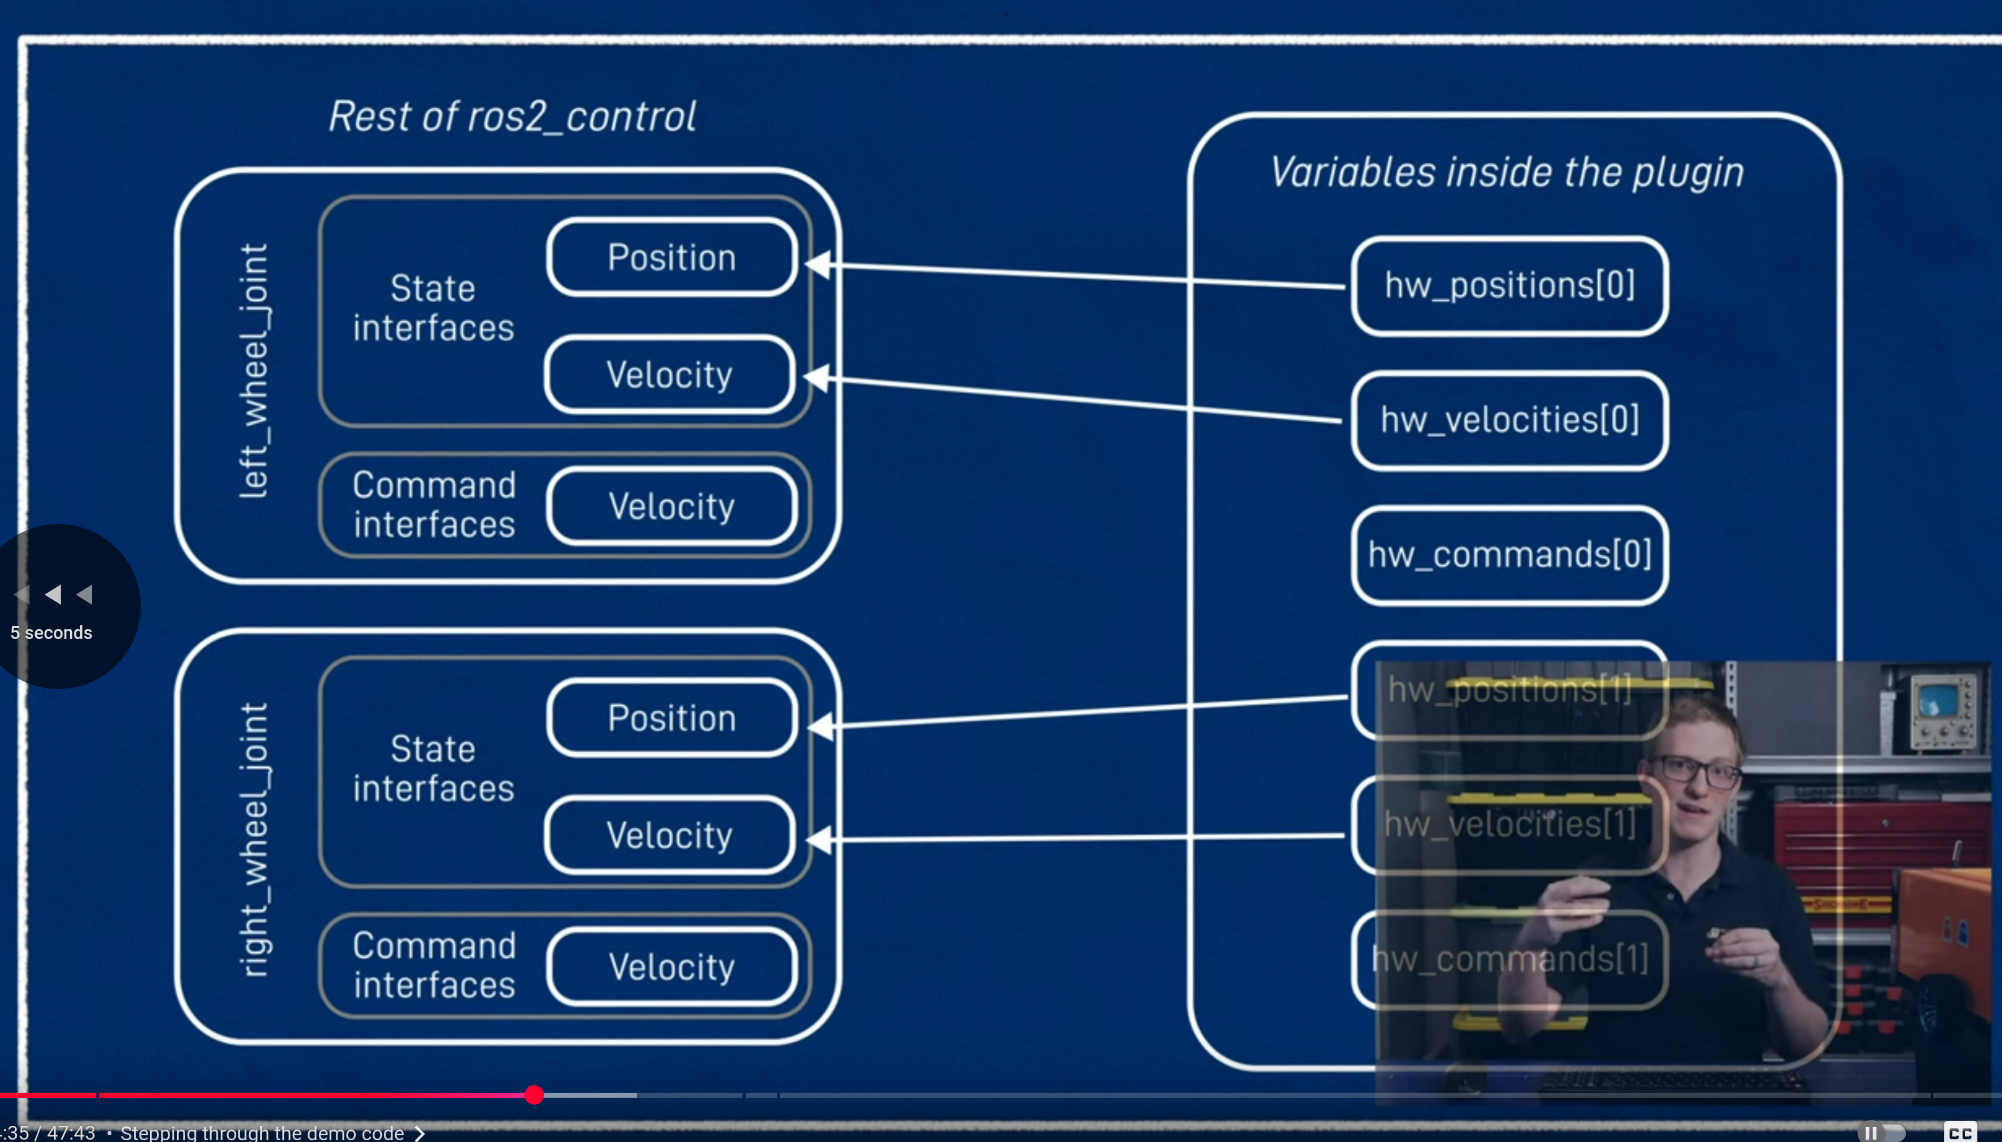

+ Keep the connection, disconnection inside the on_configurate()
 
+ for the on_activate(), we can initialize the const, parameters for PID controller etc

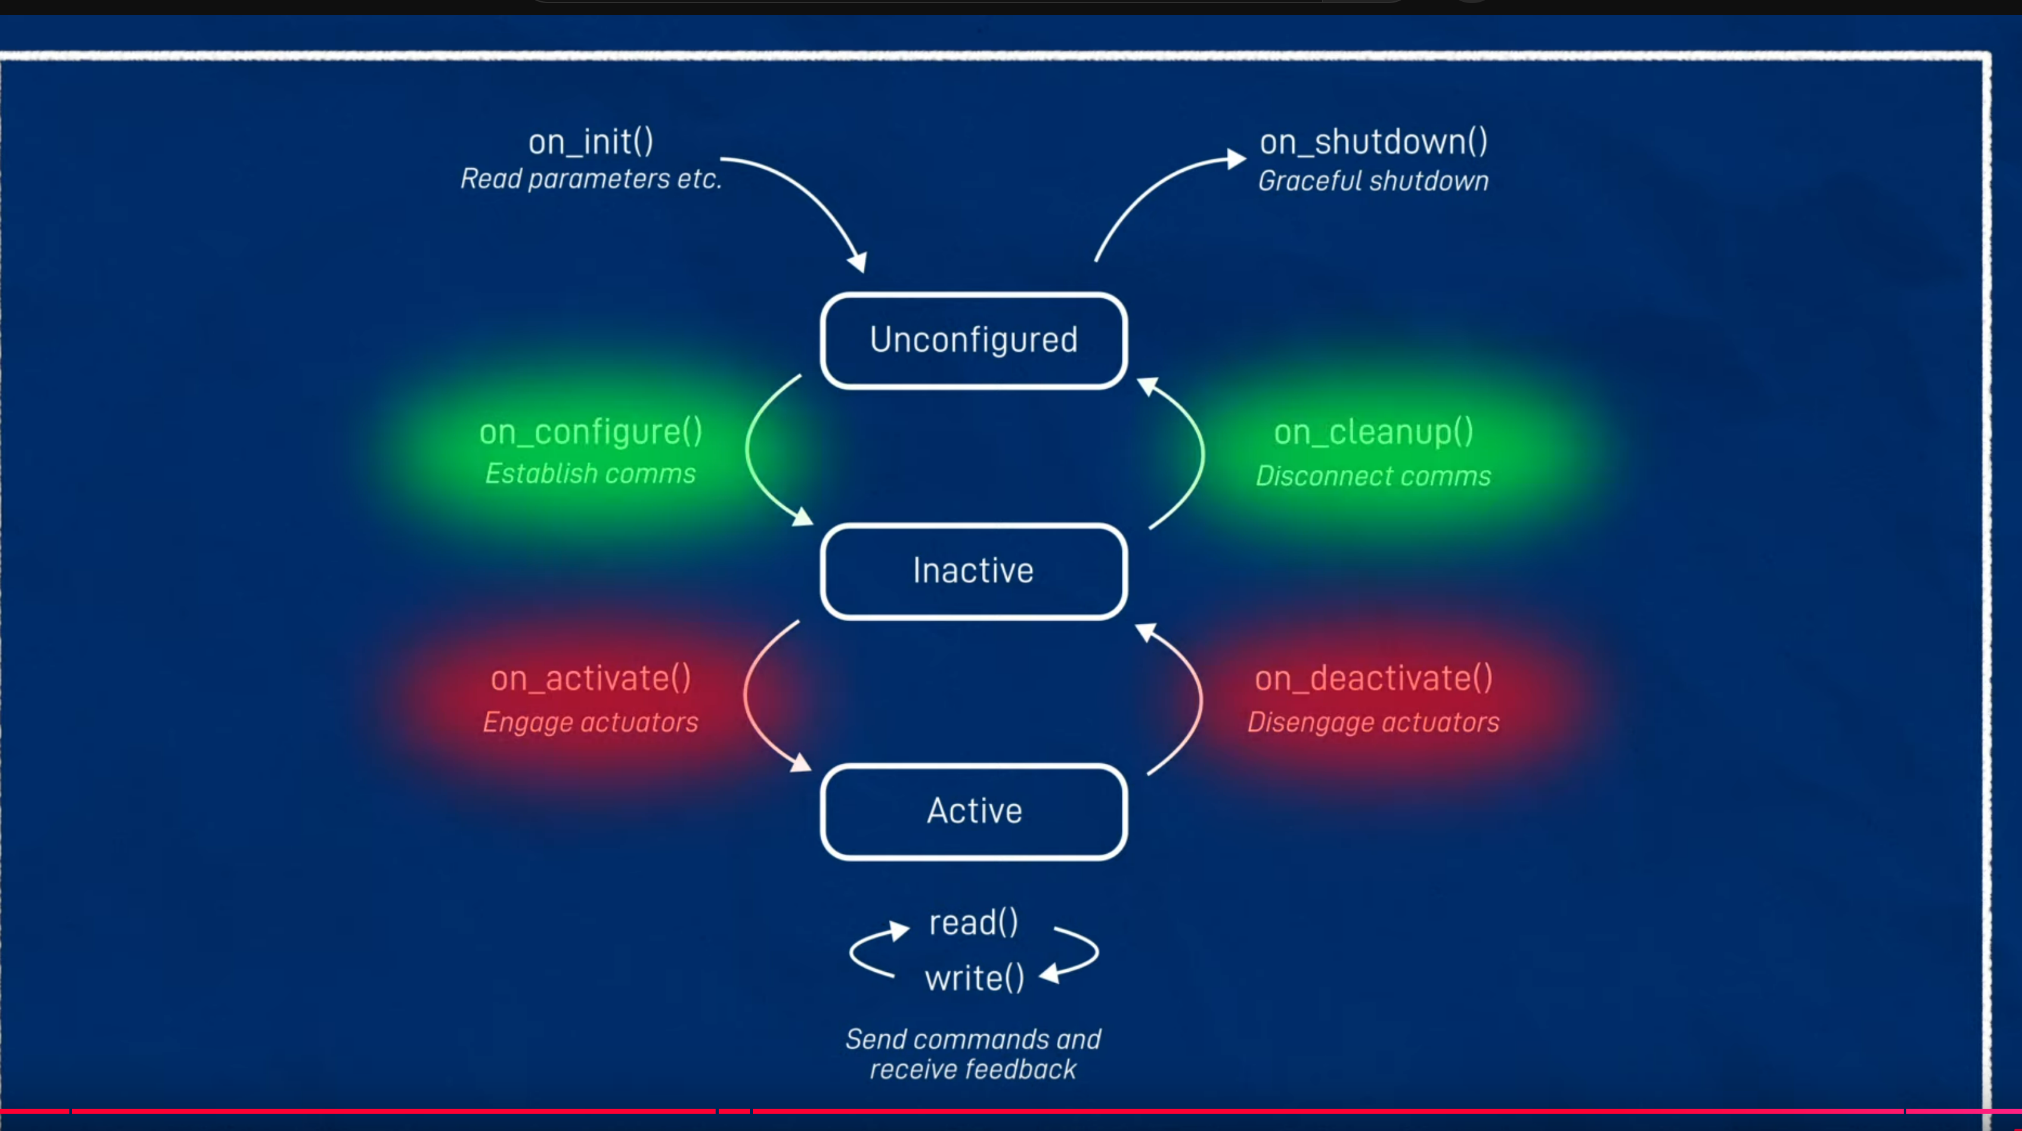

# 

# Fixed

+ 26/03/2025 17:05 we still have error in parsing the controller, even the state broadcaster.  
-> maybe we need to use other method to load these controller in launch file, 

-> may be we need to upgrade some customized code inside unitree_gazebo_system.cpp

-> solved, it was problem with foot sensor inside unitree_controller

# Pipeline for for Gazebo mode:

+ the unitree_controller utilize the pd_controller as highlevel command, we need to choose the mode (the behaviour: standing, siting, etc) from service "/set_control_mode"

## TODO:


+ check cmakelist, when to add the unitree_controller and when to add the unitree_gazebo?

+ check the unitree_controller and unitree_controller interface to correct the parameter inside the a1_gazebo_controllers.yaml

+ add foot sensor and changing mode functionality, also foot forces visualization, etc

+ check and remove unneccesary dependence, packages for all 5 packages

+ check what is these Kp, Kd value:+  



    ```cpp
    const Vector12d Kp = Vector12d::Constant(2.0); // original value is 10 
    const Vector12d Kd = Vector12d::Constant(1.0); // original value is 15 
    ``` 

error 3003 from here

```cpp
  // set_contro_mode_srv_ = get_node()->create_service<unitree_msgs::srv::SetControlMode>(
  //     "set_control_mode", 
  //     std::bind(&UnitreeController::setControlModeCallback, this, std::placeholders::_1, std::placeholders::_2));
```

foot censor??

```cpp

    FL_foot_force_sensor_broadcaster:
      type: force_torque_sensor_broadcaster/ForceTorqueSensorBroadcaster

    FR_foot_force_sensor_broadcaster:
      type: force_torque_sensor_broadcaster/ForceTorqueSensorBroadcaster

    RL_foot_force_sensor_broadcaster:
      type: force_torque_sensor_broadcaster/ForceTorqueSensorBroadcaster

    RR_foot_force_sensor_broadcaster:
      type: force_torque_sensor_broadcaster/ForceTorqueSensorBroadcaster
```

also i have removed this 
```cpp
  // const std::vector<std::string> sensor_names = this->get_sensor_names();
```

Here , why update is running before activate() finish??
```
[gzserver-1] [INFO] [1743344931.893410050] [unitree_controller_phuc]: UnitreeControllerInterface::update() called pass 4 ##########################
[ros2-7] Successfully loaded controller unitree_controller_phuc into state active

```

why in gazebo mode, we still have list_hardware_components

```cpp
phuc@pro:~/working/a1_sim/unitree_ros2(dirty_log)$ ros2 control list_hardware_components
Hardware Component 1
	name: a1_ros2_control_settings
	type: 
	plugin name: 
	state: id=3 label=active
	command interfaces
		FL_hip_joint/position [available] [claimed]
		FL_hip_joint/velocity [available] [claimed]
		FL_hip_joint/effort [available] [claimed]
		FL_hip_joint/Kp [available] [claimed]
		FL_hip_joint/Kd [available] [claimed]
		FL_thigh_joint/position [available] [claimed]
```

# Pipeline for real A1 mode:

+ it seems like initialize the UnitreeHardware::on_init() first, then initialize the UnitreeControllerInterface::on_init()

## TODO

+ Check other functionality provided in SDK

+ correct PID value, 
+ correct loop time to test 400hz (now it is 350Hz , it seems like robot can not execute the command fast enough)

+ seperate the controller interface for gazebo and real mode, then add back the foot sensor for real mode